# Predicting molecular properties with machine learning

## Intro

Developing new drugs and materials demands a comprehensive examination of the chemical compound space. Yet, this vast space remains largely uncharted because its complexity grows combinatorially with the size of molecules.

To tackle this issue, a dataset of approximately 134,000 stable small organic molecules containing carbon (C), hydrogen (H), oxygen (O), nitrogen (N), and fluorine (F) has been created. This dataset includes computed geometric, energetic, electronic, and thermodynamic properties for each molecule.

In this project, we aim to utilize this dataset, to predict the molecular properties of these small organic molecules using the Coulomb matrix representation. Specifically, we will focus on the eigenvalues of the Coulomb matrix, which are key descriptors for capturing the electronic structure of molecules and predicting their properties.

### Molecular properties in the dataset:

| No. | Property | Unit         | Description                            |
|-----|----------|--------------|----------------------------------------|
| 1   | tag      | —            | ‘gdb9’ string to facilitate extraction|
| 2   | i        | —            | Consecutive, 1-based integer identifier|
| 3   | A        | GHz          | Rotational constant                   |
| 4   | B        | GHz          | Rotational constant                   |
| 5   | C        | GHz          | Rotational constant                   |
| 6   | μ        | D            | Dipole moment                         |
| 7   | α        | a³           | Isotropic polarizability              |
| 8   | εHOMO    | Ha           | Energy of HOMO                        |
| 9   | εLUMO    | Ha           | Energy of LUMO                        |
| 10  | εgap     | Ha           | Gap (εLUMO − εHOMO)                   |
| 11  | /R2S     | a²           | Electronic spatial extent             |
| 12  | zpve     | Ha           | Zero point vibrational energy         |
| 13  | U0       | Ha           | Internal energy at 0 K                |
| 14  | U        | Ha           | Internal energy at 298.15 K           |
| 15  | H        | Ha           | Enthalpy at 298.15 K                  |
| 16  | G        | Ha           | Free energy at 298.15 K               |
| 17  | C v      | cal/mol·K    | Heat capacity at 298.15 K             |

In [2]:
import pandas as pd
import os
import opendatasets as od
from tqdm import tqdm
from pathlib import Path
import random
from coulumb_utils.xyz import read_xyz, create_dataframe_from_xyz
from coulumb_utils.calculate_coulumb_matrix import calculate_coulomb_matrix
from coulumb_utils.sort_molecules import sort_by_row_norm
from coulumb_utils.normalize import normalize_min_max
from coulumb_utils.eigen_padd import compute_eigenvalues, padd_eig
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tabulate import tabulate

# Preprocessing

The dataset is on Kaggle - https://www.kaggle.com/datasets/mariovozza5/qm9-molecules

In [3]:

dataset = "https://www.kaggle.com/datasets/mariovozza5/qm9-molecules"

if not os.path.exists("qm9-molecules"): od.download(dataset)

### Load xyz files

The dataset contains XYZ format files to store the atomatic coordinates and calculated properties of the molecules.

This is a widespread plain text format for encoding Cartesian coordinates of molecules.

https://open-babel.readthedocs.io/en/latest/FileFormats/XYZ_cartesian_coordinates_format.html

Example XYZ file from the dataset - qm9-molecules/data/qm9_460.xyz

In [4]:
work_path = Path("./qm9-molecules/")
data_path = work_path.joinpath("data")

subset_size = 1000

df = create_dataframe_from_xyz(data_path, subset_size)
df_sorted = df.sort_values('index', ascending=True)

df_sorted.head(10)

100%|██████████| 1000/1000 [00:00<00:00, 10244.15it/s]


,filename,n_atoms,index,A,B,C,mu,alpha,homo,lumo,gap,R2,zpve,U0,U,H,G,Cv
854,qm9_133,17,133,17.04187,1.92713,1.82903,0.0603,56.80,-0.3105,0.0925,0.4030,721.0614,0.160138,-197.629416,-197.622321,-197.621376,-197.659721,24.552
17,qm9_423,13,423,4.90898,3.93292,2.38617,2.5560,50.49,-0.2421,-0.0238,0.2182,545.7113,0.107628,-286.484904,-286.478789,-286.477845,-286.514513,21.712
818,qm9_812,14,812,4.97998,1.98261,1.52483,1.1030,57.57,-0.2477,-0.0022,0.2454,788.5191,0.111826,-361.648305,-361.641082,-361.640138,-361.679561,25.694
87,qm9_961,15,961,3.51132,3.36338,1.75533,3.4972,63.54,-0.2061,0.0383,0.2443,716.3821,0.126183,-304.752598,-304.745444,-304.744500,-304.783881,25.475
574,qm9_1176,17,1176,3.87909,1.85138,1.72368,4.6215,64.23,-0.2604,0.0314,0.2918,828.7651,0.147352,-305.913756,-305.905222,-305.904277,-305.945951,30.976
84,qm9_1244,17,1244,6.94554,1.14114,1.03888,1.4870,66.62,-0.2539,0.0595,0.3134,1119.7842,0.145642,-309.690179,-309.681525,-309.680580,-309.723169,31.127
762,qm9_1296,21,1296,6.28174,1.09275,0.98845,0.9066,72.30,-0.2456,0.0880,0.3336,1264.1147,0.192289,-312.128001,-312.118424,-312.117480,-312.162713,33.453
783,qm9_1397,13,1397,6.67352,1.45114,1.24798,0.6891,58.34,-0.3343,0.0003,0.3346,888.8668,0.101478,-303.533559,-303.526088,-303.525144,-303.565337,25.550
871,qm9_1411,15,1411,6.23412,1.35720,1.18722,2.1768,63.84,-0.2529,-0.0289,0.2240,965.4502,0.121699,-308.496384,-308.488145,-308.487200,-308.529306,28.587
584,qm9_1434,13,1434,8.61868,1.21327,1.07791,2.2415,61.53,-0.2644,-0.0302,0.2341,1066.4659,0.099338,-344.459234,-344.450882,-344.449937,-344.494330,26.489


### Data exploration

We visualize the data so we can get an idea of the targets we can predict and make more informed decisions on model selection and evaluation metrics.

By visualizing the distribution, we can also identify any potential outliers or skewness in the data that may require special handling during preprocessing.

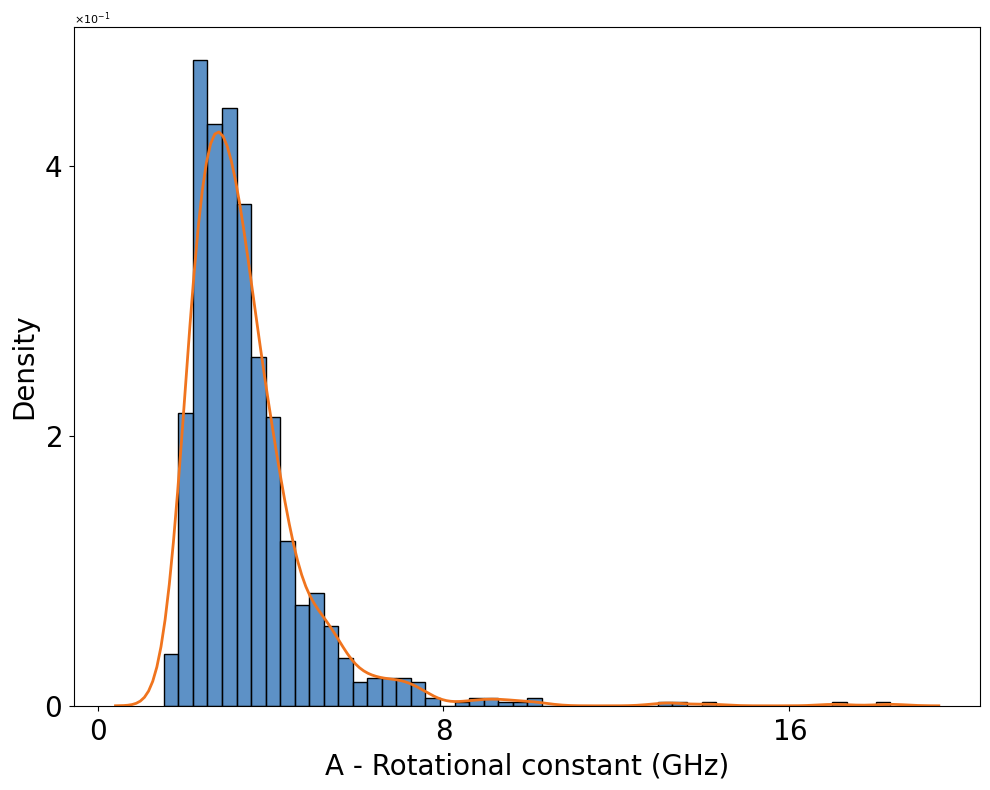

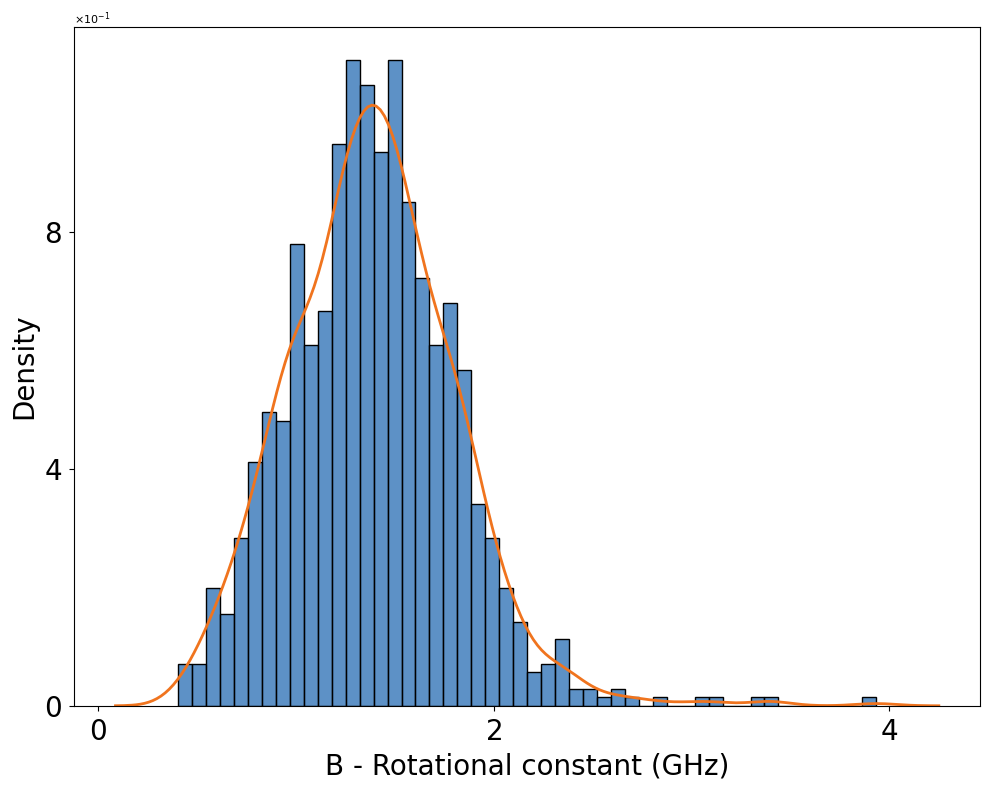

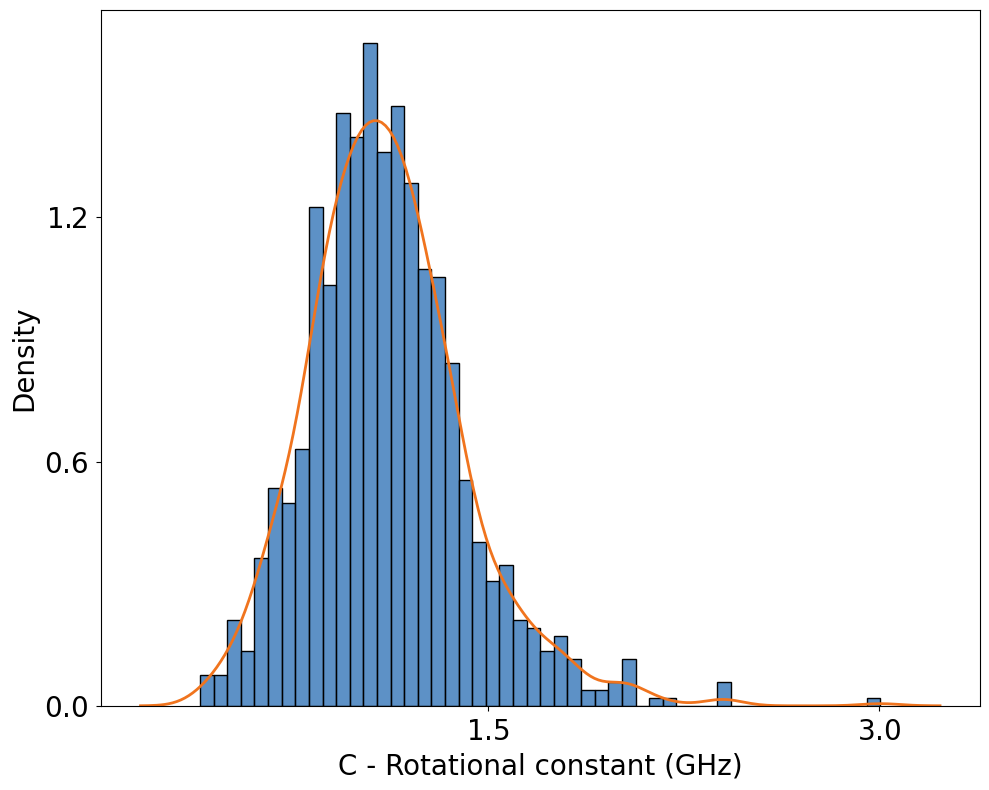

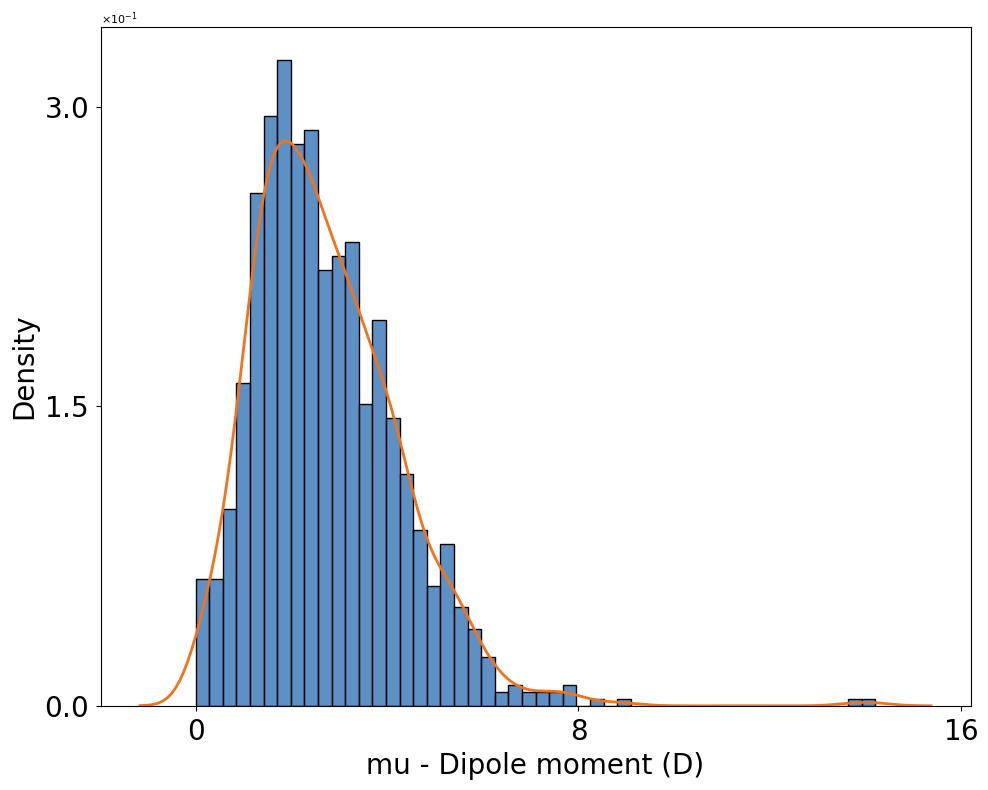

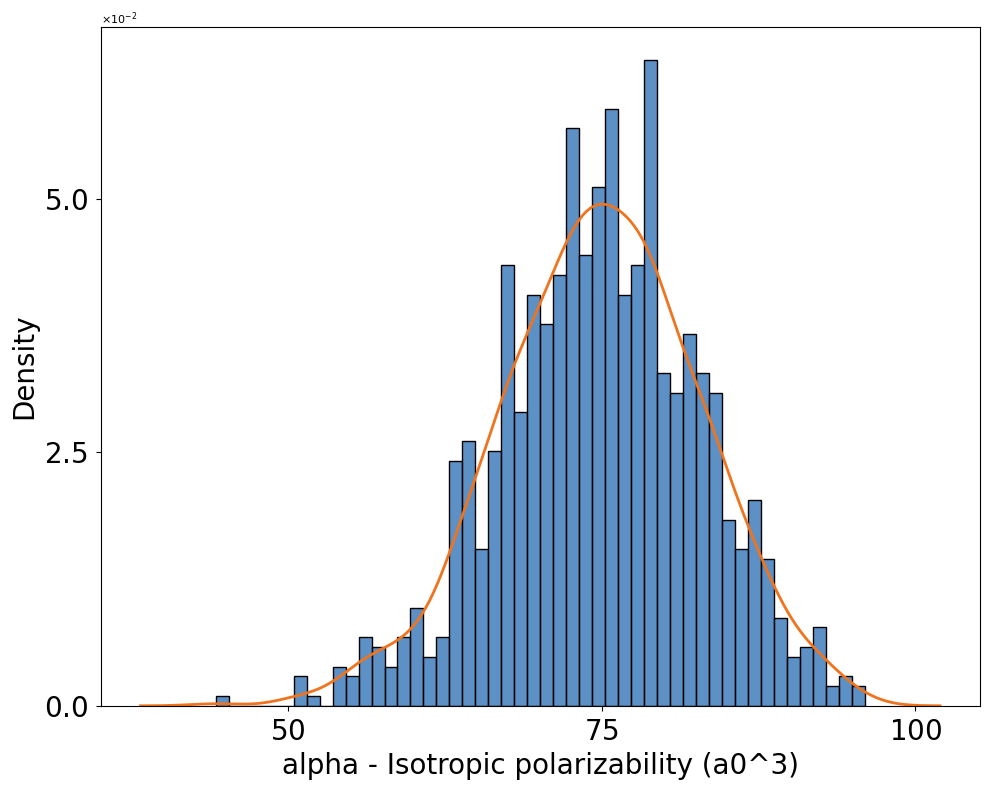

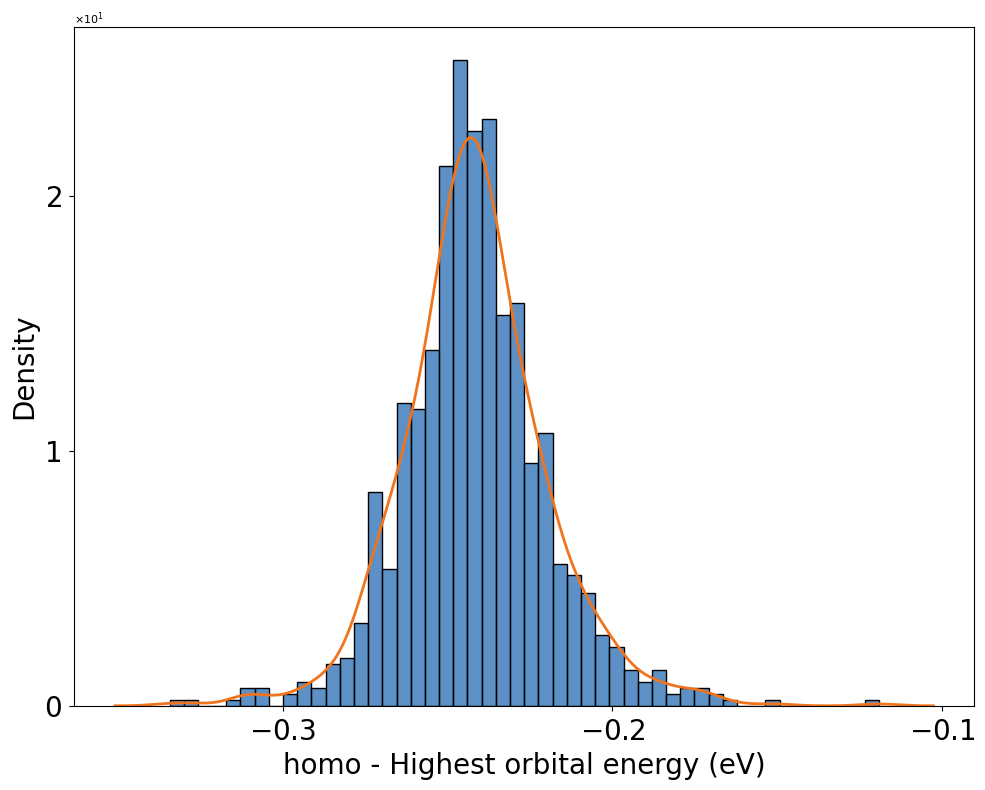

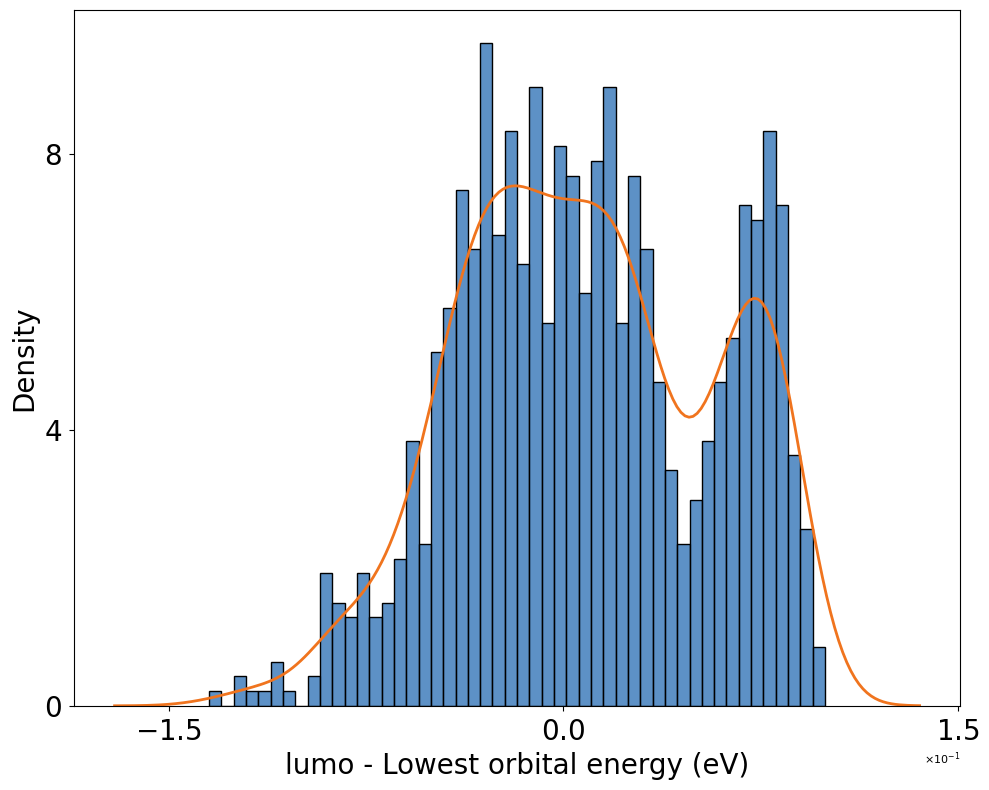

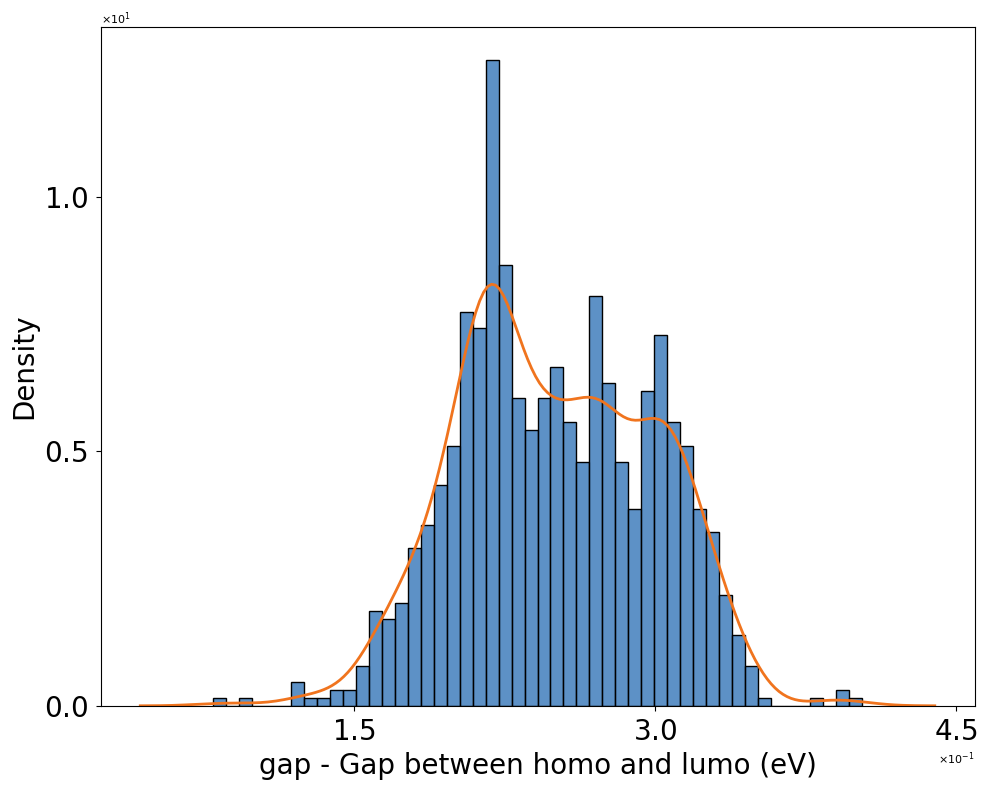

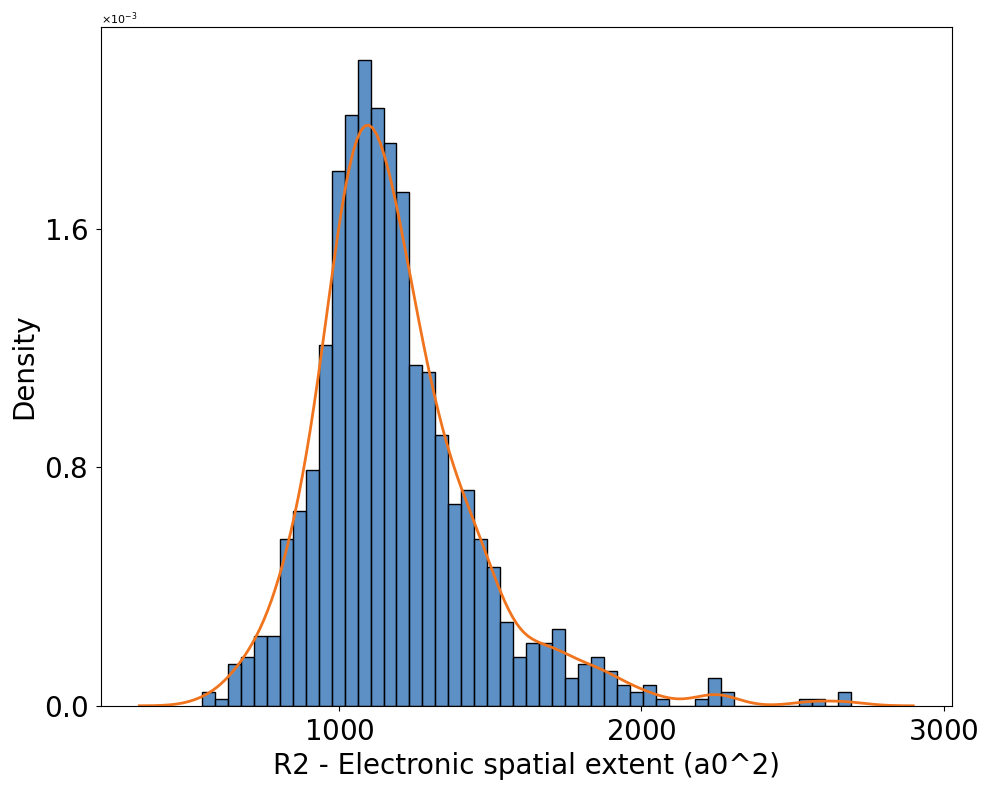

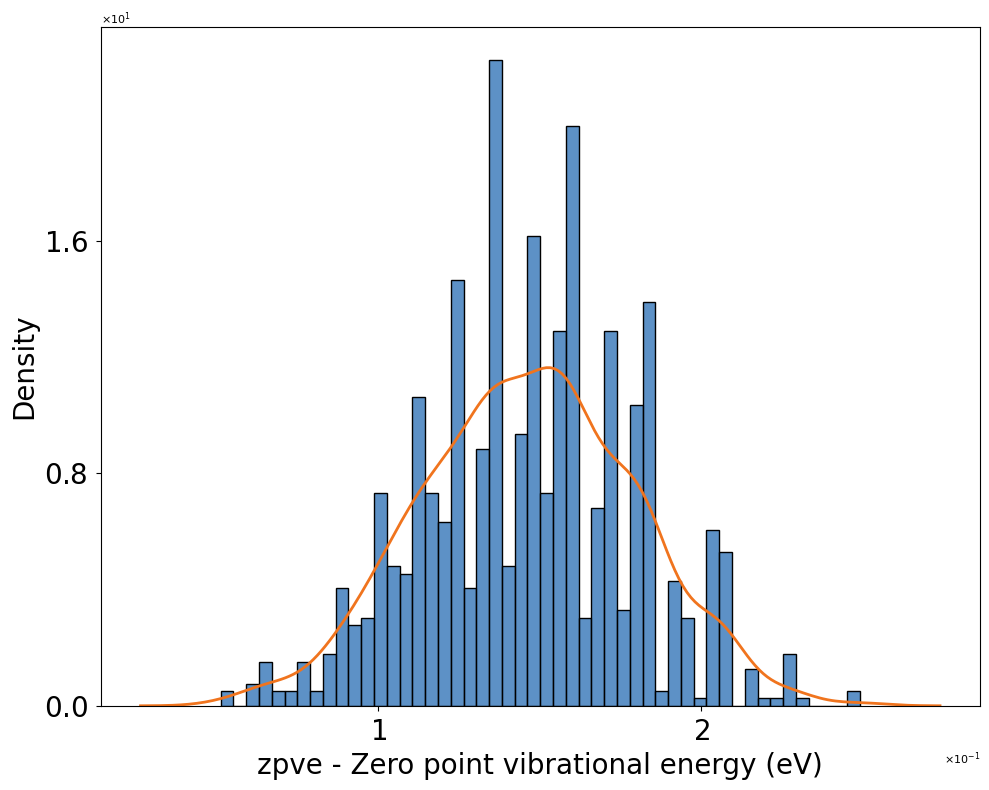

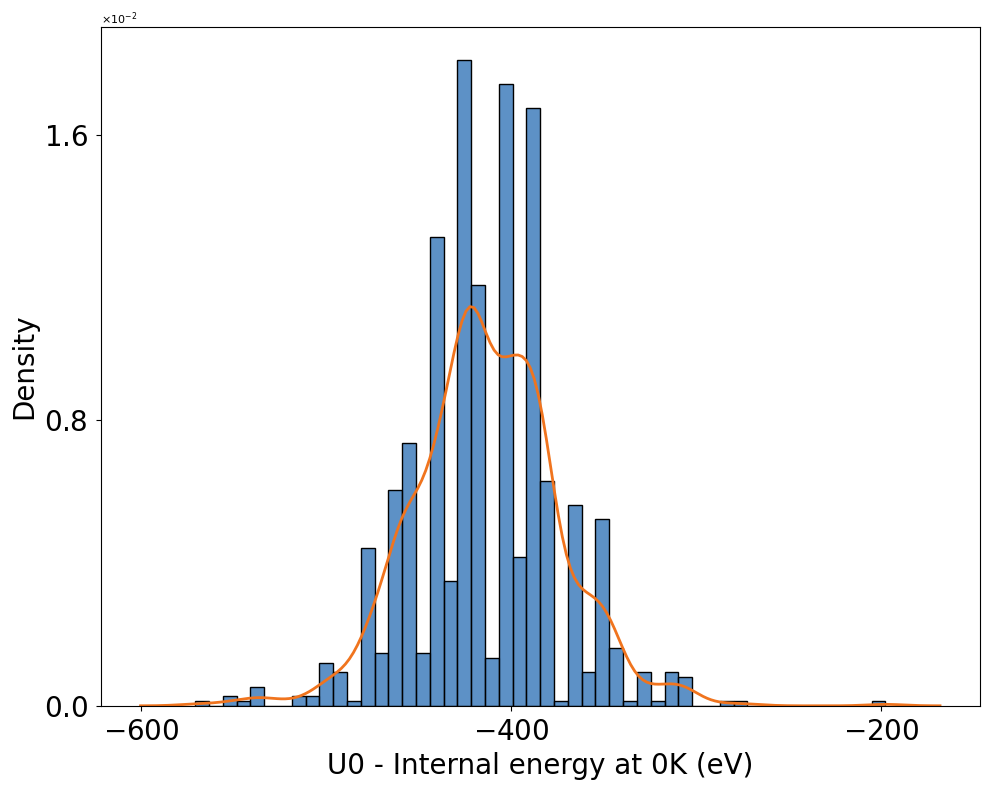

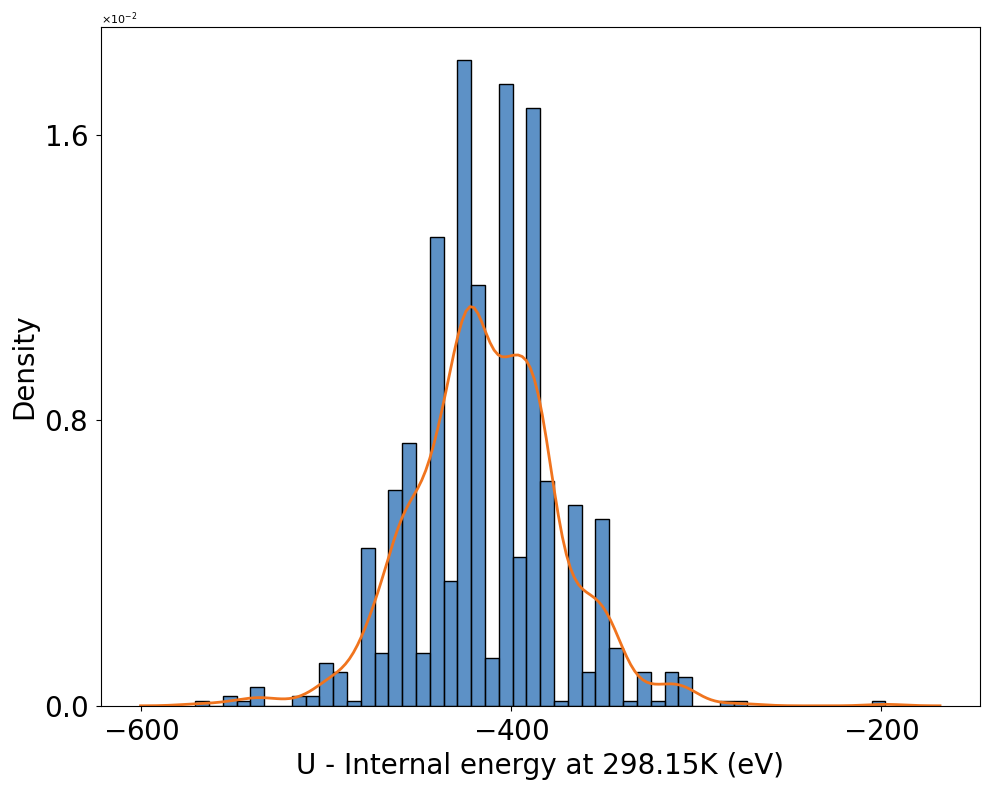

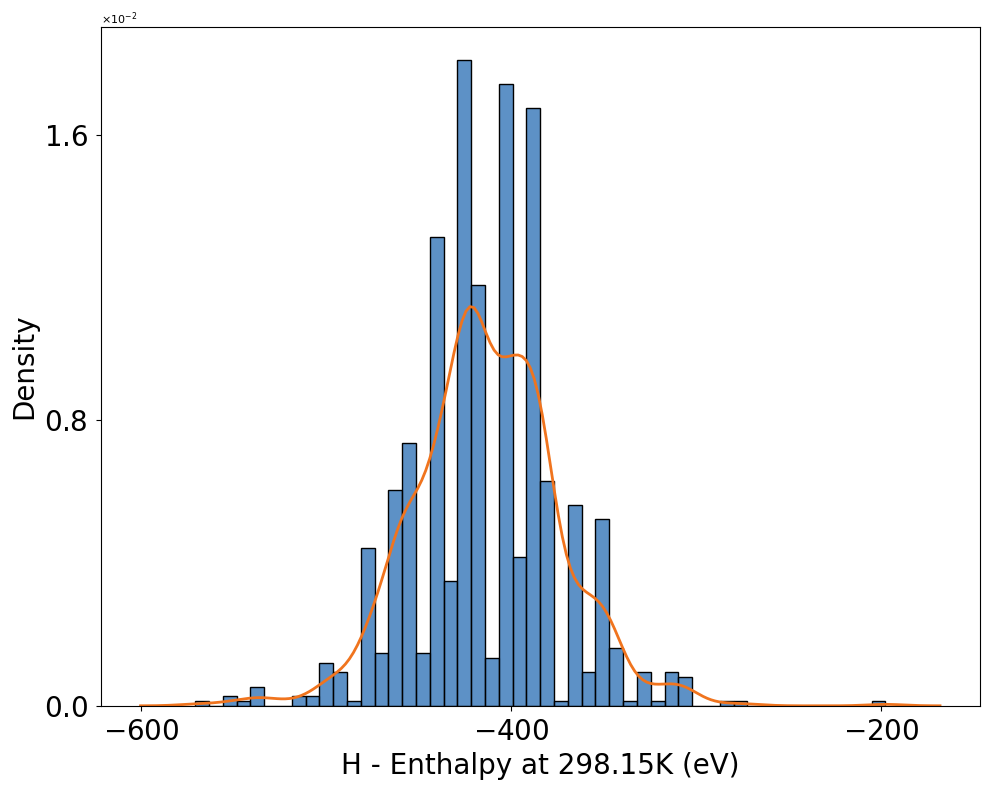

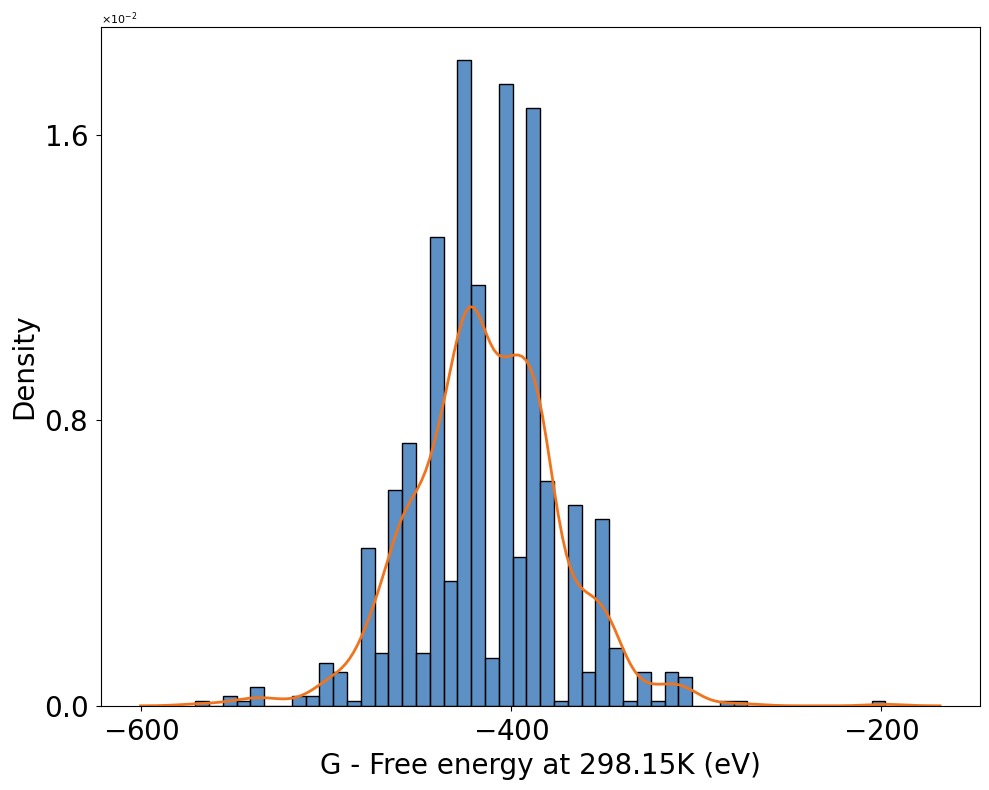

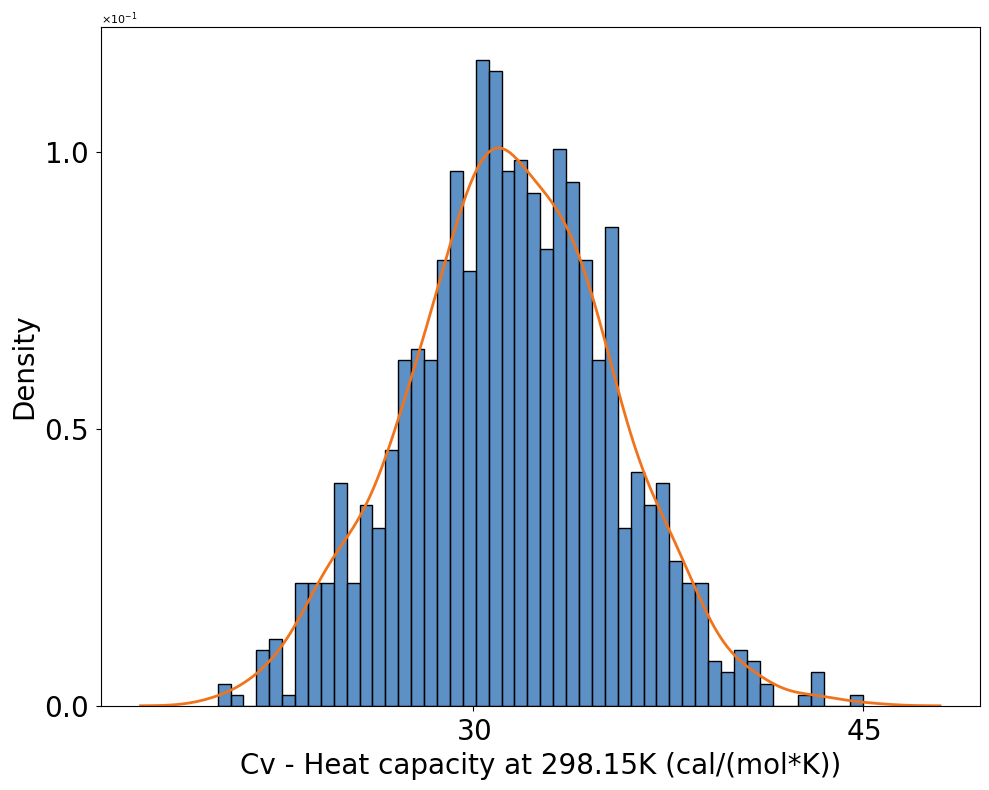

In [5]:
colors = ["#F0741E", "#276CB3"]
plt.style.use("seaborn-v0_8-paper")

target_list = ["A","B",	"C", "mu", "alpha", "homo", "lumo",	"gap", "R2", "zpve", "U0", "U", "H", "G", "Cv"]

target_labels = {
    "A": ("A - Rotational constant (GHz)", "Density"),
    "B": ("B - Rotational constant (GHz)", "Density"),
    "C": (
        "C - Rotational constant (GHz)",
        "Density",
    ),
    "mu": (
        "mu - Dipole moment (D)",
        "Density",
    ),
    "alpha": (
        "alpha - Isotropic polarizability (a0^3)",
        "Density",
    ),
    "homo": (
        "homo - Highest orbital energy (eV)",
        "Density",
    ),
    "lumo": (
        "lumo - Lowest orbital energy (eV)",
        "Density",
    ),
    "gap": (
        "gap - Gap between homo and lumo (eV)",
        "Density",
    ),
    "R2": (
        "R2 - Electronic spatial extent (a0^2)",
        "Density",
    ),
    "zpve": (
        "zpve - Zero point vibrational energy (eV)",
        "Density",
    ),
    "U0": (
        "U0 - Internal energy at 0K (eV)",
        "Density",
    ),
    "U": (
        "U - Internal energy at 298.15K (eV)",
        "Density",
    ),
    "H": (
        "H - Enthalpy at 298.15K (eV)",
        "Density",
    ),
    "G": (
        "G - Free energy at 298.15K (eV)",
        "Density",
    ),
    "Cv": (
        "Cv - Heat capacity at 298.15K (cal/(mol*K))",
        "Density",
    ),
}

for target in target_list:

    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(1, 1, 1)

    sns.histplot(
        x=df_sorted[f"{target}"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=50,
    )

    sns.kdeplot(x=df_sorted[f"{target}"], linewidth=2, color=colors[0], ax=ax)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel(target_labels[target][0], fontsize=20)
    ax.set_ylabel(target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.show()


### Correlation between features

We compute the pairwise correlation of the features so we can better understand what are the relationships between them.

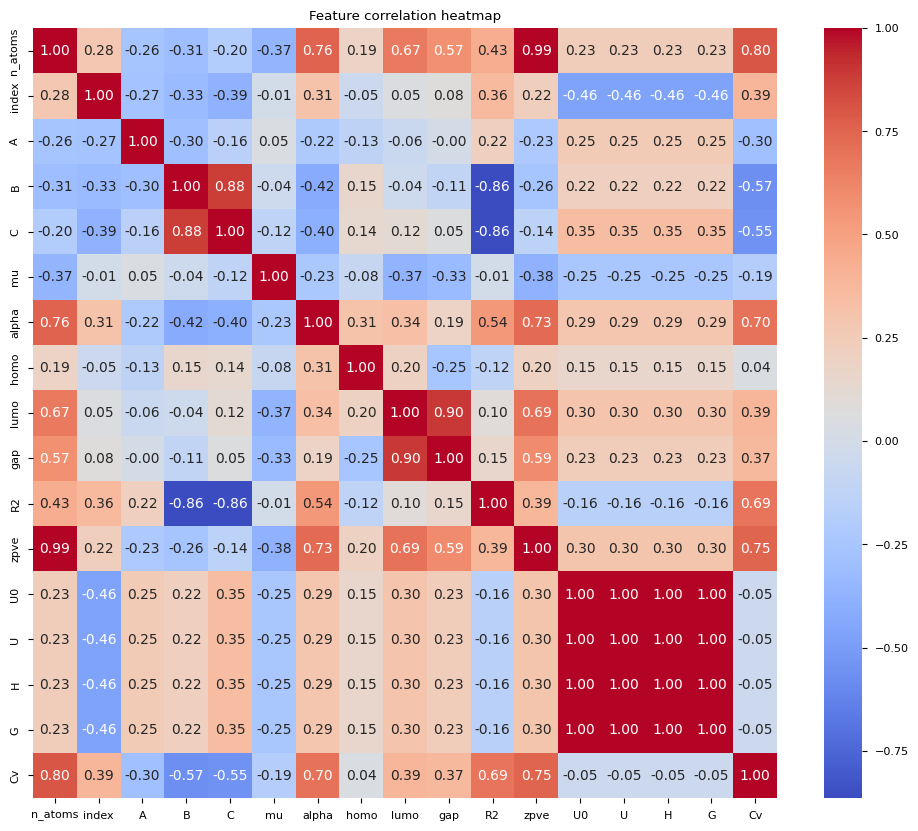

In [7]:
numeric_df = df_sorted.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title("Feature correlation heatmap")
plt.show()

Strong correlations among molecular energy properties (internal energy, enthalpy, free energy).

High correlation between the number of atoms and properties like isotropic polarizability and zero-point vibrational energy shows that molecular size significantly impacts many properties.

Rotational constant C is strongly negatively correlated with R2 (electronic spatial extent) (~ -0.86). This suggests an inverse relationship between the rotational constant C feature and electronic spatial extent.

### Calculate and visualize Coulumb matrices

A Coulumb matrix is a simple global descriptor which mimics the electrostatic interaction between nuclei.

![coulumb_matrix.png](images/coulumb_matrix.png)

The Coulomb matrix for each molecule has dimensions N x N where N is the number of atoms. The number of eigenvalues is also equal to N.

Padding is applied to the eigenvalues so we can standardize the size of the eigenvalue vectors across all molecules to a fixed dimension - max(N).

This ensures that all eigenvalue vectors have the same size, making them compatible for use in machine learning models.

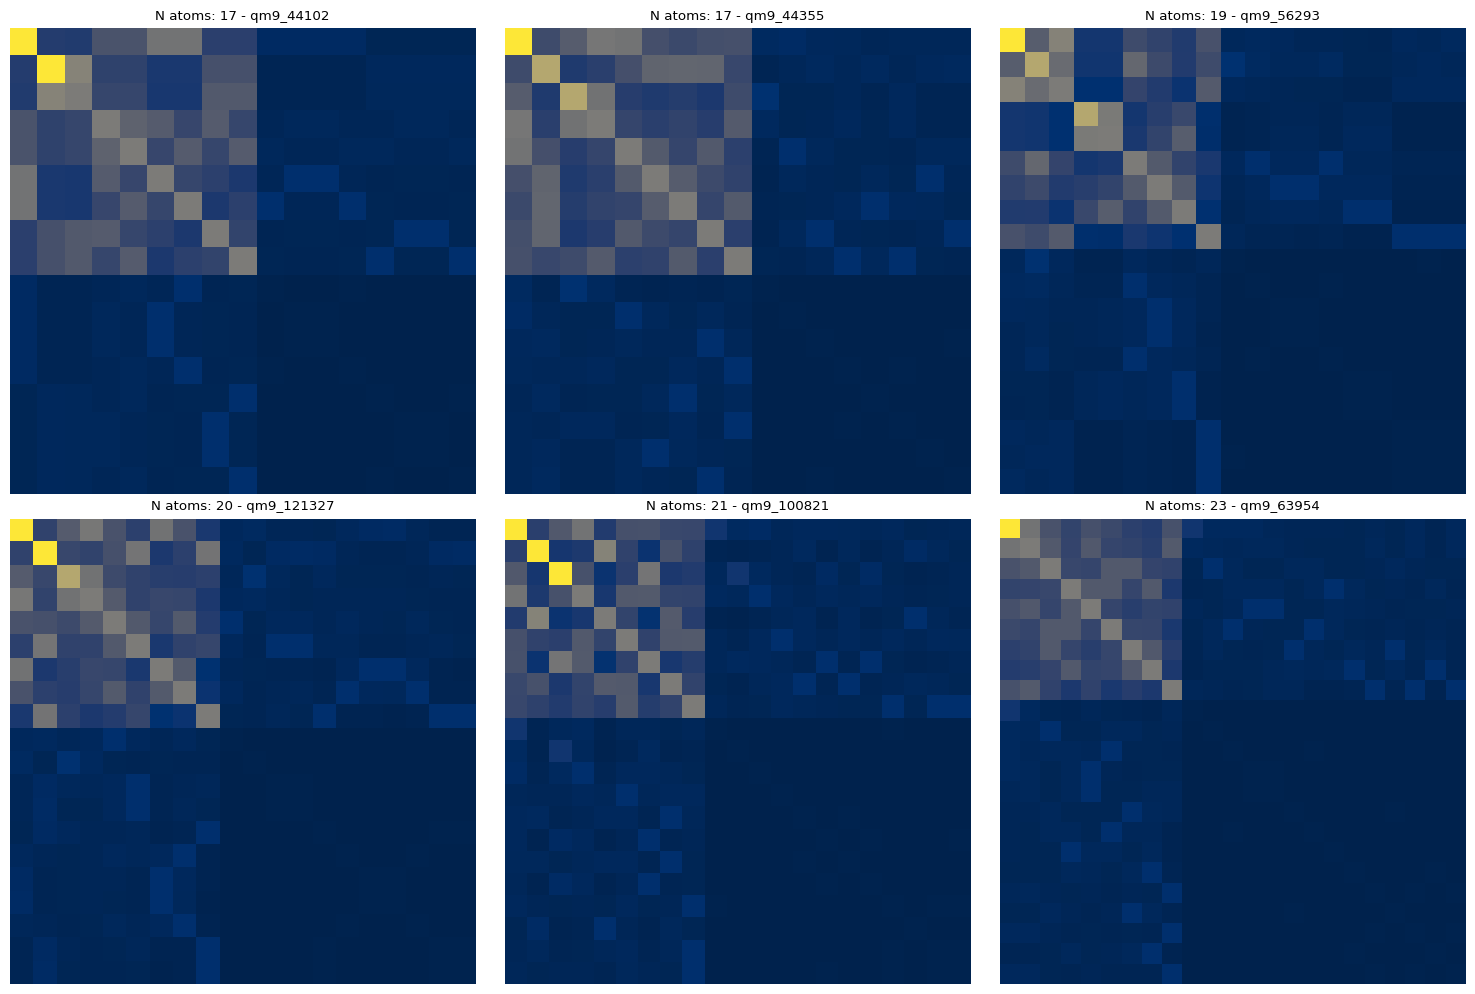

In [5]:
def display_random_images(data_path, n=6, num_cols=3):
    if not isinstance(num_cols, int):
        raise TypeError("ERROR: num_cols must be an integer")
    if not isinstance(n, int):
        raise TypeError("ERROR: n must be an integer")
    if num_cols <= 0:
        raise ValueError("ERROR: num_cols must be greater than zero")
    if n <= 0:
        raise ValueError("ERROR: n must be greater than zero")

    file_list = list(data_path.glob('*.xyz'))
    selected_files = random.sample(file_list, n)

    num_rows = (n + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols,5*num_rows))

    axes = axes.flatten()

    for i, file_path in enumerate(selected_files):
        atomic_numbers, coordinates = read_xyz(file_path)
        c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
        c_mat = sort_by_row_norm(c_mat)
        image = c_mat

        axes[i].imshow(image, cmap="cividis")
        axes[i].set_title(f"N atoms: {len(atomic_numbers)} - {file_path.stem}" )
        axes[i].axis('off')

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_random_images(data_path)

NOTE: The matrices displayed here are before the padding and they have been scaled to the size of an image (each individual square representing an element of the Coulomb matrix has different dimensions).

### Calculation and padding of eigenvalues

We find the molecule with the most atoms and adjust the size of the other Coulumb matrices based on it.

By doing this we can ensure that all matrices have the same dimension and we can use them in machine learning models.

In [6]:
resolution = df_sorted["n_atoms"].max()
print("MAX ATOM NUMBER: ",resolution)
eig_list = []
data = {}
file_list = df_sorted["filename"].to_list()
for file_path in tqdm(file_list):

    atomic_numbers, coordinates = read_xyz(data_path.joinpath(file_path + ".xyz"))
    c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
    c_mat = sort_by_row_norm(c_mat)
    eig = compute_eigenvalues(matrix=c_mat)
    eig = eig.reshape(-1, 1)
    eig = padd_eig(matrix=eig, resolution=resolution)
    eig = normalize_min_max(matrix=eig)
    data[file_path] = eig

MAX ATOM NUMBER:  25


100%|██████████| 1000/1000 [00:00<00:00, 5593.47it/s]


In [7]:
data_list = []
for filename, eig_vector in data.items():
    row = {'filename': filename}
    for i, value in enumerate(eig_vector):
        row[f'eig_{i+1}'] = value[0]
    data_list.append(row)

df_eigenvalue = pd.DataFrame(data_list)

df_eigenvalue.head()

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25
0,qm9_483,1.0,0.359689,0.189762,0.123631,0.071383,0.040220,0.004335,0.003928,0.000000,0.000352,0.002209,0.001611,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464
1,qm9_509,1.0,0.408681,0.246738,0.123992,0.060049,0.034974,0.000000,0.000859,0.003091,0.004705,0.005520,0.005490,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915
2,qm9_527,1.0,0.448216,0.245408,0.132659,0.086707,0.036754,0.000000,0.001542,0.003208,0.004832,0.007703,0.006070,0.006746,0.006640,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247
3,qm9_559,1.0,0.428377,0.183954,0.132322,0.068973,0.042705,0.000000,0.001998,0.002796,0.005611,0.004025,0.004737,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548
4,qm9_562,1.0,0.328554,0.189873,0.135620,0.082882,0.028632,0.000000,0.000550,0.002910,0.005871,0.004937,0.005313,0.005324,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764


### Choosing a target feature

We are choosing the feature that we want to predict. In this case it's the heat capacity (Cv).

After that we merge it with the eigenvalues to create the final dataset that we'll be using for the training and testing of the models.

In [8]:
target = "Cv" # can be one of ["A","B","C","mu","alpha","homo","lumo","gap","R2","zpve","U0","U","H","G","Cv"]

df_merged = pd.merge(df_eigenvalue, df_sorted[['filename', target]], on='filename', how='left')

df_merged.head(10)

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25,Cv
0,qm9_483,1.0,0.359689,0.189762,0.123631,0.071383,0.040220,0.004335,0.003928,0.000000,0.000352,0.002209,0.001611,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,20.187
1,qm9_509,1.0,0.408681,0.246738,0.123992,0.060049,0.034974,0.000000,0.000859,0.003091,0.004705,0.005520,0.005490,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,22.098
2,qm9_527,1.0,0.448216,0.245408,0.132659,0.086707,0.036754,0.000000,0.001542,0.003208,0.004832,0.007703,0.006070,0.006746,0.006640,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,23.932
3,qm9_559,1.0,0.428377,0.183954,0.132322,0.068973,0.042705,0.000000,0.001998,0.002796,0.005611,0.004025,0.004737,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,19.792
4,qm9_562,1.0,0.328554,0.189873,0.135620,0.082882,0.028632,0.000000,0.000550,0.002910,0.005871,0.004937,0.005313,0.005324,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,21.051
5,qm9_610,1.0,0.427356,0.205141,0.120894,0.077288,0.046448,0.000000,0.001777,0.002863,0.003643,0.005277,0.005891,0.005706,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,22.227
6,qm9_949,1.0,0.377365,0.228679,0.167184,0.057263,0.067247,0.024308,0.000000,0.006553,0.005712,0.004442,0.003836,0.003450,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,21.832
7,qm9_978,1.0,0.350259,0.252232,0.161095,0.100300,0.038954,0.020268,0.003906,0.003089,0.001905,0.000422,0.000000,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,24.081
8,qm9_1159,1.0,0.344540,0.291450,0.184611,0.094191,0.042186,0.020118,0.000000,0.001490,0.002942,0.005424,0.005406,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,27.481
9,qm9_1714,1.0,0.403102,0.228007,0.106462,0.122993,0.067971,0.033643,0.000000,0.001201,0.001619,0.002617,0.005201,0.004891,0.004549,0.004598,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,25.478


# Training

We train multiple regression models and compare their performance on our dataset:
- Linear regression
- Random forest
- SVR (Epsilon-support vector regression)
- K-nearest neighbors
- XGBoost (Extreme gradient boosting)
- Ridge regression

We perform hyperparameter optimization for each of the models in order to find the best hyperparameters.

We use cross-validation to assess how well the models will generalize on unseen data which helps with detecting overfitting and ensures the models perform well on new data.

After the training, we compare all of the models and find which is the best for the current task.

### Hyperparameter optimization

In [23]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_mse = -grid_search.best_score_
    return best_params, best_mse

### Cross-validation

In [24]:
def evaluate_with_cv(models, X, y, cv=5):
    results = []
    for model in models:
        model_name = type(model).__name__
        
        cv_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
        
        results.append({
            'Model': model_name,
            'Mean CV MSE': cv_mse.mean(),
            'Std CV MSE': cv_mse.std(),
            'Mean CV R2': cv_r2.mean(),
            'Std CV R2': cv_r2.std()
        })
    return pd.DataFrame(results)

### Comparison between heat capacity models

In [45]:
def regression_model_comparison(df, target):
    X = df.drop(['filename', target], axis=1)
    y = df[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    models = [
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        SVR(),
        KNeighborsRegressor(),
        XGBRegressor(random_state=42, verbosity=0),
        Ridge(),
    ]
    
    param_grids = {
        'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'SVR': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']},
        'KNeighborsRegressor': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']},
        'XGBRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 10]},
        'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100]}
    }
    
    cv_results = evaluate_with_cv(models, X_scaled, y)
    print("Cross-validation results:")
    print(tabulate(cv_results, headers='keys', tablefmt='pretty'))

    tuning_results = []
    for model in models:
        model_name = type(model).__name__
        if model_name in param_grids:
            best_params, best_mse = hyperparameter_tuning(model, param_grids[model_name], X_train, y_train)
            tuning_results.append({
                'Model': model_name,
                'Best params': best_params,
                'Best CV MSE': best_mse
            })
    
    tuning_results_df = pd.DataFrame(tuning_results)
    print("\nHyperparameter tuning results:")
    print(tabulate(tuning_results_df, headers='keys', tablefmt='pretty'))
    
    final_results = []
    for model in models:
        model_name = type(model).__name__
        if model_name in param_grids:
            model.set_params(**tuning_results_df.loc[tuning_results_df['Model'] == model_name, 'Best params'].values[0])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        final_results.append({
            'Model': model_name,
            'Test MSE': mse,
            'Test R2': r2
        })
    
    final_results_df = pd.DataFrame(final_results)
    print("\nFinal test set results:")
    print(tabulate(final_results_df, headers='keys', tablefmt='pretty'))
    
    cv_results.plot(kind='bar', x='Model', y=['Mean CV MSE', 'Mean CV R2'], figsize=(10, 6))
    plt.title('Cross-validation performance')
    plt.ylabel('Score')
    plt.show()
    
    final_results_df.plot(kind='bar', x='Model', y=['Test MSE', 'Test R2'], figsize=(10, 6))
    plt.title('Test set performance')
    plt.ylabel('Score')
    plt.show()
    
    best_model = final_results_df.loc[final_results_df['Test MSE'].idxmin()]
    best_model_name = best_model['Model']
    best_model_instance = None

    for model in models:
        if type(model).__name__ == best_model_name:
            best_model_instance = model
            break
    
    print(f"\nBest model based on lowest test MSE: {best_model_name}")

    return best_model_instance, X_test, y_test

# Evaluation

We train the models and we show the cross-validation results, hyperparameter tuning results and the test set results.

Cross-validation results:
+---+-----------------------+-------------------+--------------------+--------------------+---------------------+
|   |         Model         |    Mean CV MSE    |     Std CV MSE     |     Mean CV R2     |      Std CV R2      |
+---+-----------------------+-------------------+--------------------+--------------------+---------------------+
| 0 |   LinearRegression    | 6.700944132264576 | 7.9350327815363135 | 0.516494949478093  | 0.4587298558404578  |
| 1 | RandomForestRegressor |  3.4767609759575  | 0.8561997249541318 | 0.7035014719968297 | 0.08759902217375327 |
| 2 |          SVR          | 4.449589187379209 | 4.569213899478546  | 0.6792295247392967 | 0.2577347793574514  |
| 3 |  KNeighborsRegressor  |   4.23874458536   | 1.5377715898358577 | 0.6477647976857325 | 0.09840659516151888 |
| 4 |     XGBRegressor      | 3.436198895221197 | 0.9869528306604016 | 0.7077192897133925 | 0.08315606330615932 |
| 5 |         Ridge         | 6.692367938896514 | 7.9401864186

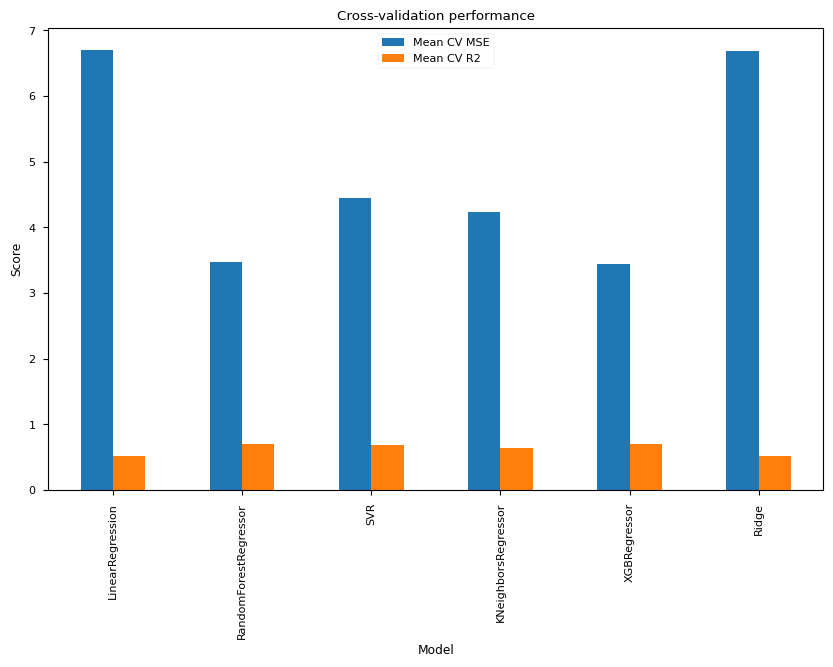

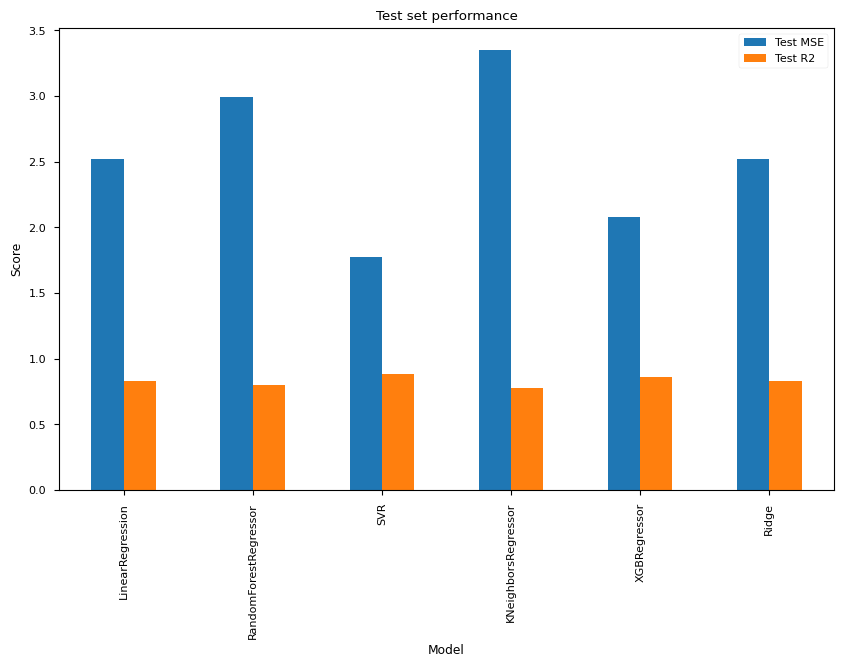


Best model based on lowest test MSE: SVR


In [46]:
best_model, X_test, y_test = regression_model_comparison(df_merged, target=target)

### Cross-validation performance:

- XGBoost and Random forest achieve the lowest mean cross-validation MSE values (3.44 and 3.48), indicating that these models generalize well during cross-validation.
- XGBoost achieves the highest mean cross-validation R² (0.71), slightly better than Random forest (0.70). This suggests that XGboost explains slightly more variance in the target variable compared to Random forest.
- Random forest and XGBoost exhibit low standard deviations for both cross-validation MSE and cross-validation R², showing consistent performance across folds.
- Linear regression and Ridge regression, while performing poorly overall (high mean cross-validation MSE, low mean cross-validation R²), have high standard deviations, indicating that their performance is highly variable across folds.
- Linear regression and Ridge regression both perform poorly with the highest Mean CV MSE (~6.7) and lowest Mean CV R² (~0.52), indicating they are less suitable for this problem.

### Hyperparameter tuning performance:

- Hyperparameter tuning considerably improved models like SVR and XGBoost. SVR's best MSE improved to 1.84 after tuning, the best among all models and XGBoost's best MSE reached 1.9, showcasing that parameter tuning led to significant optimization.
- Random forest benefited from deeper trees (max_depth: 20) and more estimators (200), indicating the importance of capturing complex patterns.
- SVR improved with a higher regularization parameter (C: 10) and the RBF kernel (instead of linear kernel), emphasizing the role of non-linear relationships.
- Ridge regression required a very small regularization parameter (alpha: 0.1), suggesting a need for minimal penalization.

### Test set performance:

- Based on cross-validation and test set results, XGBoost is the most reliable models for this task.
- XGBoost emerges as the top-performing model on the test set, with a low test MSE (2.08) and the highest R² (0.86), confirming its ability to generalize well.
- While SVR showed good performance after tuning in cross-validation, its test set performance suggests some overfitting because there is a large gap between cross-validation and test set performance. Also the best hyperparameters for SVR include a high regularization parameter (C=10) and the use of the RBF kernel.
- Linear regression and Ridge regression show consistently poor performance across all metrics.

### Best model predictions for heat capacity

We show the predictions of the best model (based on lowest test mean squared error) for heat capacity.

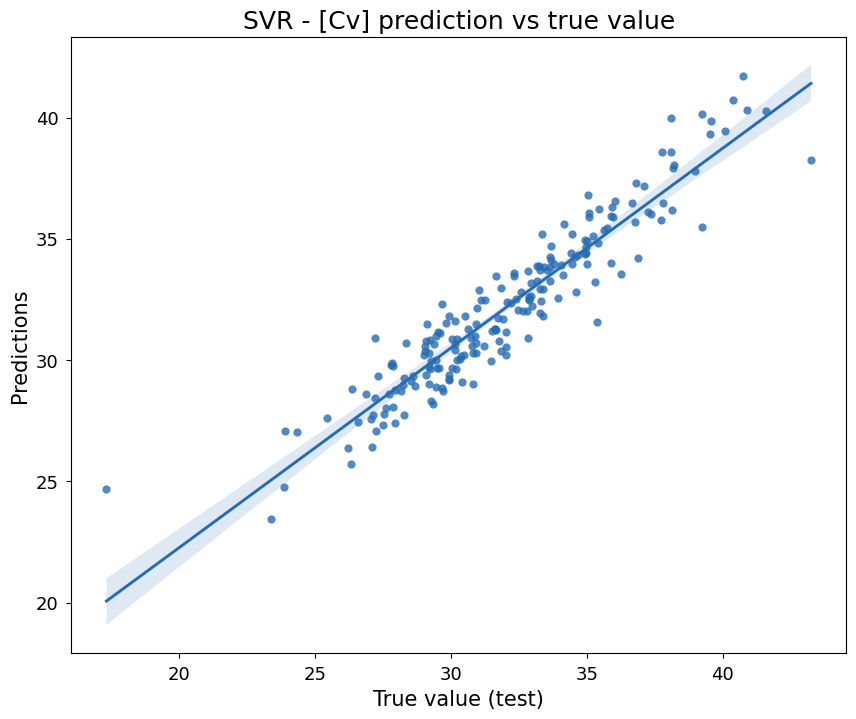

In [47]:
y_pred = best_model.predict(X_test)

best_model_name = type(best_model).__name__

plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, color=colors[1], scatter_kws={'s': 35})
plt.xlabel("True value (test)", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title(f"{best_model_name} - [{target}] prediction vs true value", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

We can see that the model predicts the heat capacity from the structure of the molecule quite well. 

### Comparison between isotropic polarizability models

We train the same models again on a dataset with isotropic polarizability (alpha) as the target variable.

Cross-validation results:
+---+-----------------------+--------------------+--------------------+---------------------+---------------------+
|   |         Model         |    Mean CV MSE     |     Std CV MSE     |     Mean CV R2      |      Std CV R2      |
+---+-----------------------+--------------------+--------------------+---------------------+---------------------+
| 0 |   LinearRegression    | 26.11851948510614  | 28.572066448392935 | 0.6089782071615921  | 0.28482213272670825 |
| 1 | RandomForestRegressor | 31.829758794590013 | 48.00899339537514  | 0.5700368754286744  | 0.5228732528544249  |
| 2 |          SVR          | 37.04778094838234  | 51.077858319353716 | 0.48550178412300227 | 0.5460805120767627  |
| 3 |  KNeighborsRegressor  | 31.177539895999995 | 40.59504191946583  | 0.5511188211759028  | 0.42779858630361806 |
| 4 |     XGBRegressor      | 33.82749605941616  | 51.046857701231474 | 0.5442633603606944  | 0.5560030703072799  |
| 5 |         Ridge         | 25.8934192430143

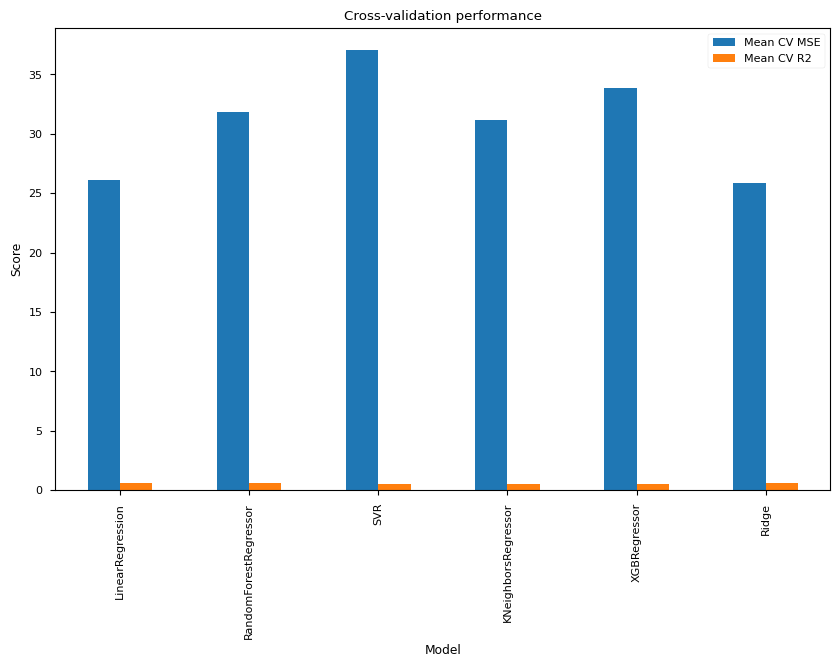

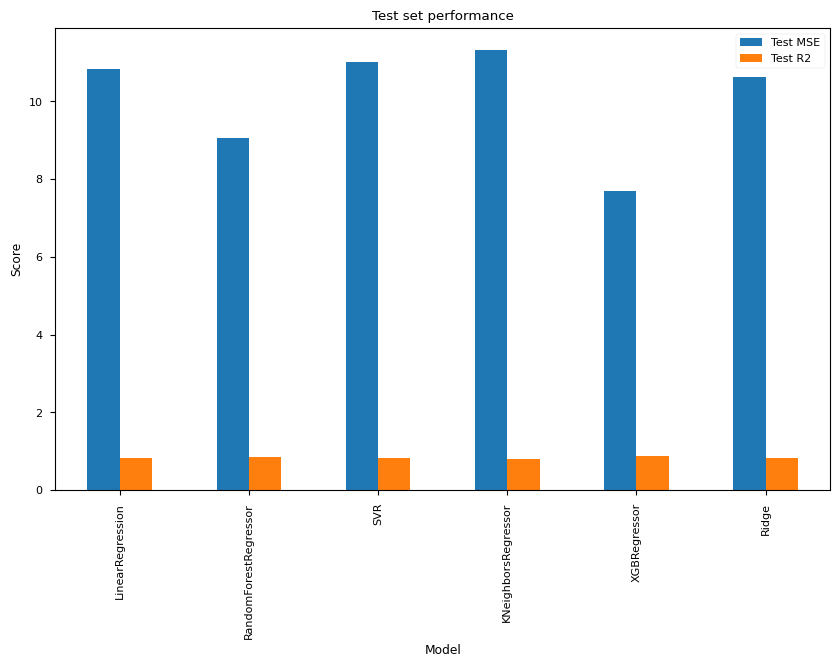


Best model based on lowest test MSE: XGBRegressor


In [60]:
target = "alpha" # can be one of ["A","B","C","mu","alpha","homo","lumo","gap","R2","zpve","U0","U","H","G","Cv"]

df_merged = pd.merge(df_eigenvalue, df_sorted[['filename', target]], on='filename', how='left')

best_model, X_test, y_test = regression_model_comparison(df_merged, target=target)

### Cross-validation performance:

- Linear regression and Ridge regression have the lowest mean cross-validation MSE (26.12 and 25.89), indicating they performed better during cross-validation than other models. Their mean cross-validation R² values (around 0.61) are also the highest among all models, suggesting they explain a decent proportion of variance in the target variable.
- SVR has the worst mean cross-validation MSE (37.05) and the lowest R² (0.49), which implies poorer performance during cross-validation compared to other models.
- XGBRegressor shows slightly better MSE than SVR but still lags behind Linear regression and Ridge regression in terms of mean cross-validation R².
- Random forest and K-nearest neighbors show intermediate performance, with mean CV MSE values around 31-32 and mean CV R² values around 0.55.

### Hyperparameter tuning performance:

- Tuning has significantly improved the models' performance, as seen in their MSE.
- XGBoost has the lowest MSE after tuning (9.15), indicating it benefits the most from hyperparameter optimization.
- Random forest and SVR also show substantial improvement, with tuned MSE values of 10.27 and 11.67.
- Ridge regression and K-nearest neighbors benefit less, but their tuning still reduces MSE compared to the untuned cross-validation scores.

### Test set performance:

- XGBoost achieves the best performance on the test set with the lowest test MSE (7.71) and the highest test R² (0.87), making it the strongest overall model.
- Random forest achieves test MSE of 9.07 and test R² of 0.85 which makes it the second-best model.
- Linear regression and Ridge regression perform similarly, with MSE values around 10.6–10.8 and R² values around 0.81–0.82. They provide stable and consistent performance but are outperformed by XGBoost and Random forest.
- SVR and K-nearest neighbours show slightly lower performance, with MSE values around 11 and R² values around 0.81.

### Best model predictions for isotropic polarizability

Now the best model (based on lowest test mean squared error) is XGBoost. We show its predictions for isotropic polarizability.

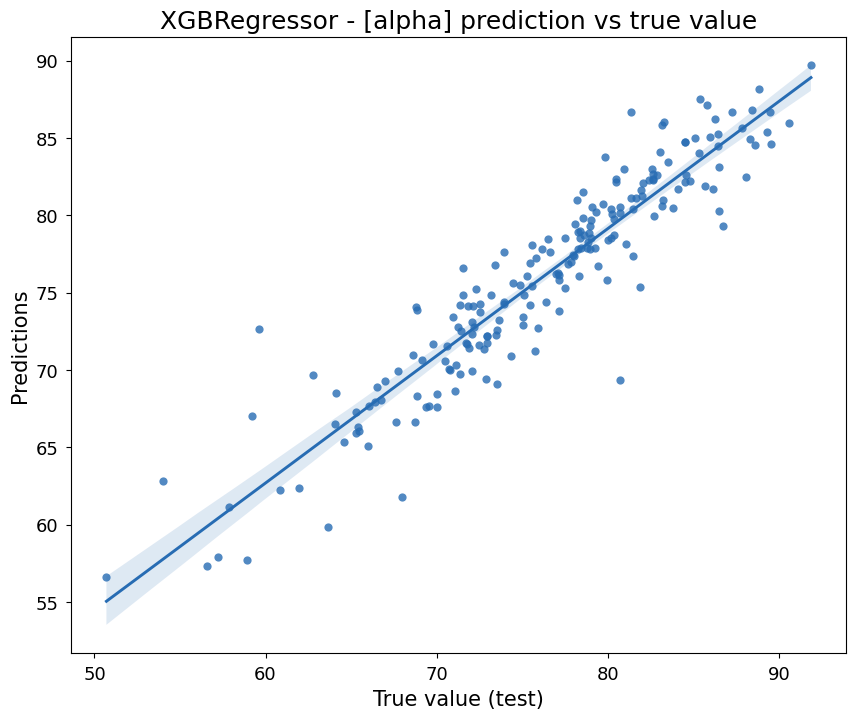

In [61]:
y_pred = best_model.predict(X_test)

best_model_name = type(best_model).__name__

plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, color=colors[1], scatter_kws={'s': 35})
plt.xlabel("True value (test)", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title(f"{best_model_name} - [{target}] prediction vs true value", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Again we can see that the model predicts the isotropic polarizability from the structure of the molecule quite well. 

# Conclusion

- Performed data exploration on the QM9 dataset. We plotted the distributions of the 17 features of the dataset so we could better understand the data, correlation between features and decide which features we should choose for prediction.
- After the data exploration, we had to transform the XYZ format files from the dataset into Coulumb matrices which represent the structure of molecules. We extracted the coordinates for all of the atoms and created a Coulumb matrix for each molecule in the dataset. Then we extracted the eigenvalues of the Coulumb matrices and applied padding to them so the dimension of the data could become suitable for training machine learning models.
- Next we trained and evaluated multiple regression models on the eigenvalues of the Coulumb matrices to predict heat capacity and isotropic polarizability.
- As part of the training, we performed hyperparameter tuning, cross-validation and compared the following models - Linear regression, Random forest, SVR, K-nearest neighbours, XGBoost and Ridge regression.
- We found out that the best model out of all these for our task is XGBoost. Some of the models did not perform well even after hyperparameter tuning.
- If we had more time to work on the project we would've tried to extend the dataset by adding molecules with more atoms and compare how these models would perform when the size of the molecules is significantly increased. Also, it would be worth trying to train and evaluate models with the 17 current existing features (and possibly calculating and adding more physical/chemical properties) as the training dataset without the XYZ coordinates and compare how this approach performs compared to the current approach that uses the 3D structure of the molecules. 